# Ran.Données 2022 - Computer vision : classification et segmentation
Auteurs : Gabriel Leclerc (version 2021) et Catherine Bouchard (versions 2021/2022)

<table><tr>
<td> <img src="https://iid.ulaval.ca/wp-content/themes/iid/images/logo-iid-Institut-intelligence-donnees.svg"> </td>
<td> <img src="http://www.cttei.com/wp-content/uploads/logo-ulaval-reseaux-sociaux-300x158.jpg"> </td>
<td> <img src="https://neuro.ulaval.ca/sites/default/files/CERVO_Centre_Logo.png"> </td>
</tr></table>

<img src="https://miro.medium.com/max/1400/1*8gmgaAkFdI-9OHY5cA93xQ.png" width="800" align="center"/>

## Computer Vision vs. LIDAR

<img src="https://miro.medium.com/max/1400/0*GT6nwGUBVV4uXdtz">
Computer Vision (right) and LiDAR — How they look separately (source: https://medium.com/analytics-vidhya/inside-a-car-with-its-own-mind-960d792c3b42)


### Team LIDAR : Waymo, Argo AI, Cruise, Aurora, Mobileye
<img src="https://miro.medium.com/max/1400/0*u-FgWEtXRiNNjuf9">

### Team CV : Tesla

*“The whole road system is meant to be navigated with passive optical, or cameras, and so once you solve cameras or vision, then autonomy is solved. If you don’t solve vision, it’s not solved.”* - Elon Musk


## C'est quoi, la vision numérique?

"Domaine scientifique et branche de l’intelligence artificielle qui traite de la façon dont les ordinateurs peuvent acquérir une compréhension de haut niveau à partir d'images ou de vidéos numériques. Du point de vue de l'ingénierie, il cherche à comprendre et à automatiser les tâches que le système visuel humain peut effectuer."

<img src="https://thiscatdoesnotexist.com/" width="400" align="center"/>

Source : thiscatdoesnotexist.com

In [1]:
# Lib used
import warnings; warnings.simplefilter('ignore')

import io
import os
import time
import copy
import urllib
import requests

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})

!pip install -U scikit-image # need upgraded version
import skimage
import skimage.io
import skimage.filters
import skimage.transform
import skimage.morphology
import skimage.segmentation

from PIL import Image
import cv2

import numpy as np

import scipy
import scipy.ndimage
from scipy.stats.kde import gaussian_kde

from IPython import display

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.optim import Adam

from torchvision import transforms
from torch.autograd import Variable

!pip install skan
!pip install pooch
import skan
import skan.draw

axisoff = lambda ax: [x.axis('off') for x in ax.ravel()]

Requirement already up-to-date: scikit-image in /home/catherine/.local/lib/python3.8/site-packages (0.19.2)


## C'est quoi, une image?
Du point de vue d'un ordinateur, une image est une matrice 2-dimensions (image en tons de gris) ou 3-dimensions (images couleur).

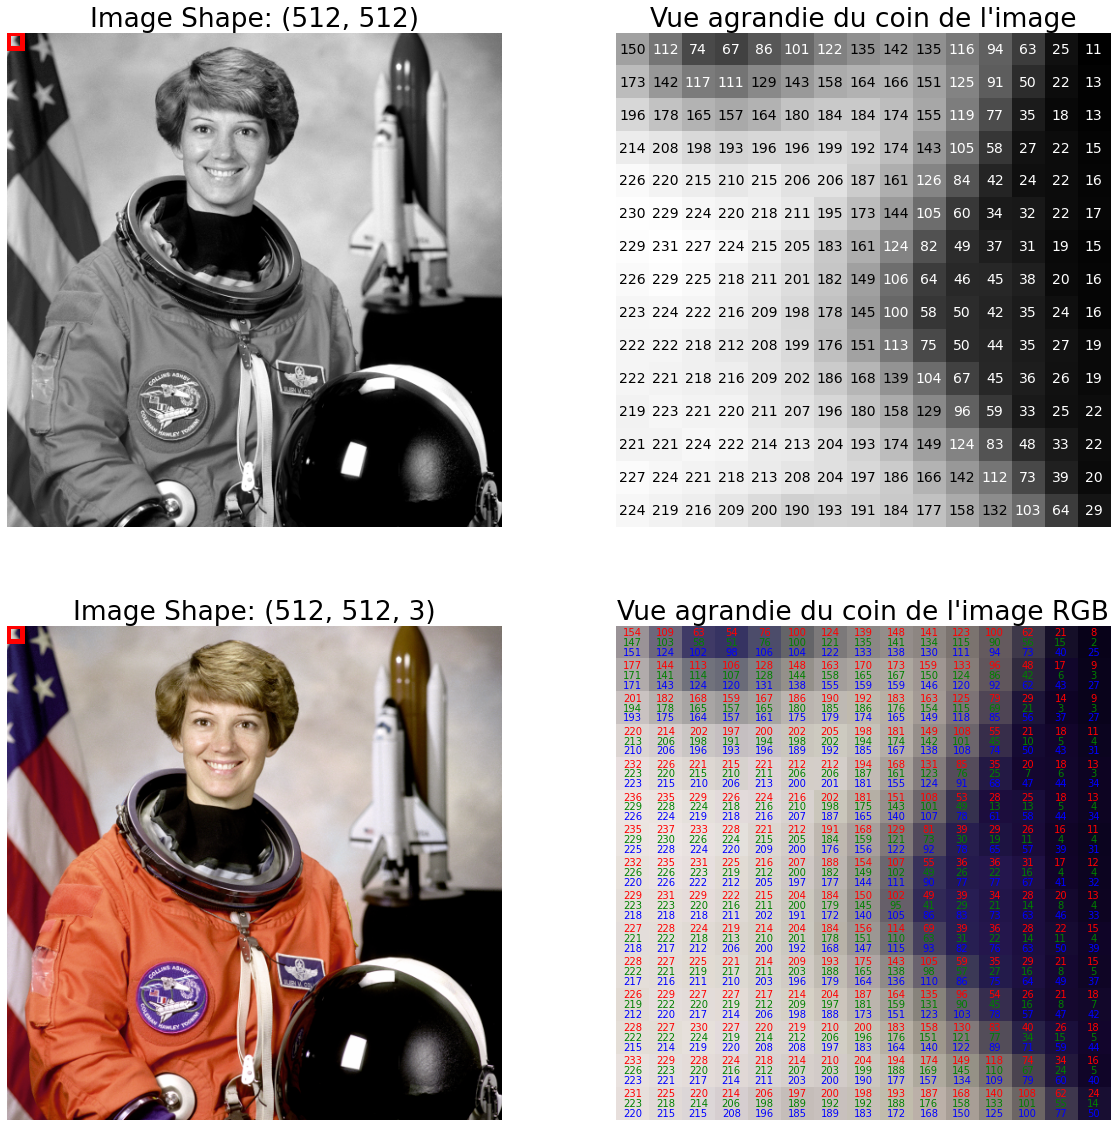

In [2]:
matplotlib.rcParams.update({'font.size': 22})

###---Parameters---###
crop_size = 15
###----------------###

image_color = skimage.data.astronaut()
image_gray = np.mean(image_color, axis=2).astype(np.uint8) # RGB to Grayscale
output_shape = (image_gray.shape[0]//20, image_gray.shape[1]//20)
image_crop = image_gray[:crop_size,:crop_size]

fig, axs = plt.subplots(2, 2, figsize=(20,20))

axs[0,1].imshow(image_crop, cmap='gist_gray')
axs[1,1].imshow(image_color[:crop_size,:crop_size])
axs[0,1].set_title('Vue agrandie du coin de l\'image')
axs[1,1].set_title('Vue agrandie du coin de l\'image RGB')
for x in range(image_crop.shape[1]):
    for y in range(image_crop.shape[0]):
        rgb_pixel_intensity = image_color[y, x]
        grayscale_pixel_intensity = image_crop[y, x]
        adaptative_gray_color = 'black' if grayscale_pixel_intensity > 255/2 else 'white'

        axs[0,1].text(x, y, s=grayscale_pixel_intensity, 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=14,
            color=adaptative_gray_color) # Gray channel
        axs[1,1].text(x, y-0.3, s=rgb_pixel_intensity[0], 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='red') # Red channel
        axs[1,1].text(x, y, s=rgb_pixel_intensity[1], 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='green') # Green channel
        axs[1,1].text(x, y+0.3, s=rgb_pixel_intensity[2],
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='blue') # Blue channel

axs[0,0].imshow(image_gray, cmap='gist_gray')
axs[0,0].set_title(f"Image Shape: {image_gray.shape}")

# Add rectangle patches of the cropped regions
rectG = matplotlib.patches.Rectangle(
    (0, 0), width=crop_size, height=crop_size,
    linewidth=5, edgecolor='red', facecolor='none')
rectRGB = matplotlib.patches.Rectangle(
    (0, 0), width=crop_size, height=crop_size, 
    linewidth=5, edgecolor='red', facecolor='none')
axs[0,0].add_patch(rectG)
axs[1,0].add_patch(rectRGB)

axs[1,0].imshow(image_color)
axs[1,0].set_title(f"Image Shape: {image_color.shape}")
axisoff(axs)
print()

[(0.0, 1.0, 0.0, 1.0),
 (-0.5, 14.5, 14.5, -0.5),
 (0.0, 1.0, 0.0, 1.0),
 (-0.5, 14.5, 14.5, -0.5),
 (-0.5, 14.5, 14.5, -0.5),
 (-0.5, 14.5, 14.5, -0.5)]

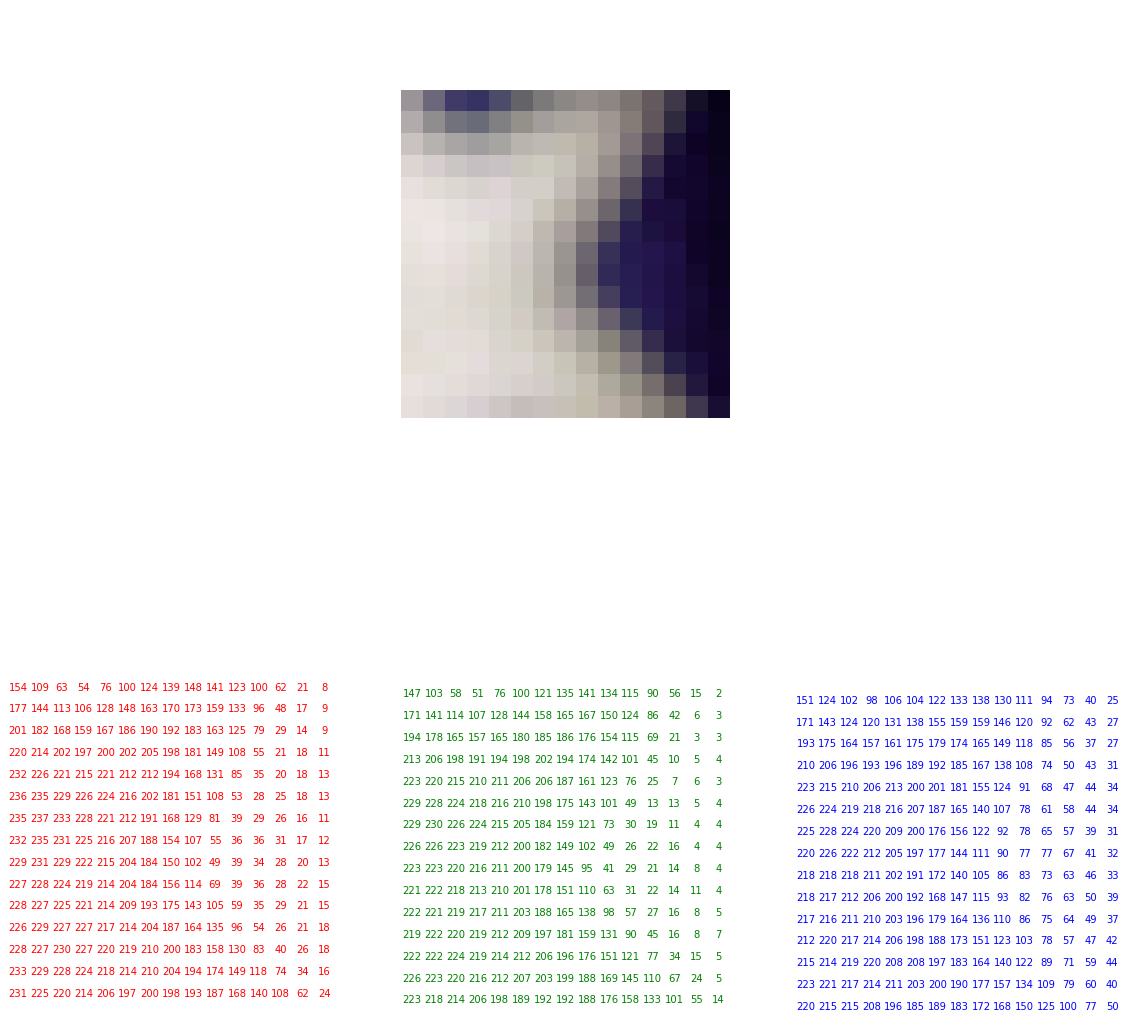

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
axs[1,0].imshow(image_crop*0, cmap='binary')
axs[1,1].imshow(image_crop*0, cmap='binary')
axs[1,2].imshow(image_crop*0, cmap='binary')

for x in range(image_crop.shape[1]):
    for y in range(image_crop.shape[0]):
        rgb_pixel_intensity = image_color[y, x]
        grayscale_pixel_intensity = image_crop[y, x]
        adaptative_gray_color = 'black'

        axs[1,0].text(x, y-0.3, s=rgb_pixel_intensity[0], 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='red') # Red channel
        axs[1,1].text(x, y, s=rgb_pixel_intensity[1], 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='green') # Green channel
        axs[1,2].text(x, y+0.3, s=rgb_pixel_intensity[2],
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=10,
            color='blue') # Blue channel

axs[0,1].imshow(image_color[:crop_size,:crop_size])        
axisoff(axs)

# Traitement d'images classique
Il existe d'innombrables opérations de traitement d'images. Par exemple, ci-dessus, nous avons converti une image RGB à 3 canaux en une image à un canal en niveaux de gris.

Nous allons commencer par introduire les opérations morphologiques, qui sont des opérations où chaque pixel de l'image est ajusté en fonction de la valeur des autres pixels de son voisinage. 

## Données
Nous allons appliquer des opérations de traitement d'images à une image de neurone, credit: https://www.fiercebiotech.com/research/ucsd-targets-dendritic-spines-promising-alzheimer-s-approach

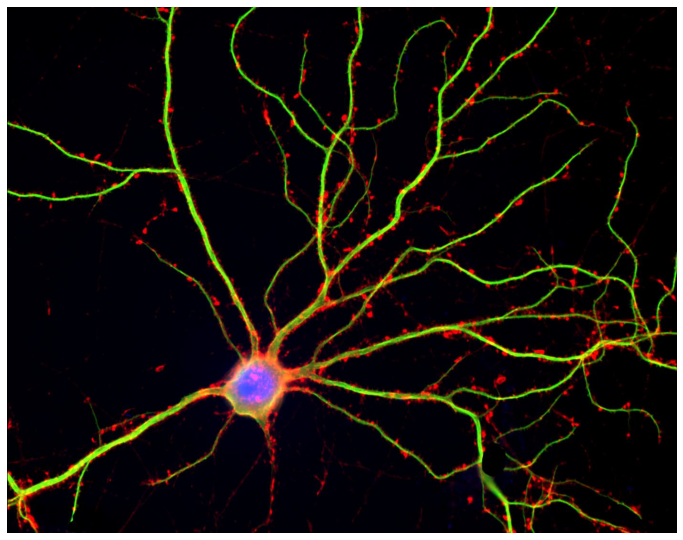

In [4]:
response = requests.get('https://qtxasset.com/2016-04/neuron.jpg?PCK0DzNbfCngFqlsA9peo5TjhOAXJE0x')
img = skimage.io.imread(io.BytesIO(response.content))
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')
print()

## Étapes de prétraitement
Les opérations morphologiques de base sont appliquées sur une image binaire, c'est-à-dire que nous parlons de pixels dont la valeur est soit 0, soit 1.

Pour y parvenir, nous allons appliquer une série d'opérations. Plus précisément, nous allons faire ce qui suit :
1. Convertir une image RGB en une image en niveaux de gris.
2. Appliquer un filtre gaussien pour atténuer le contenu de l'image afin d'obtenir un masque de meilleure qualité (avec $\sigma$ = 3)
3. Trouver un bon seuil pour séparer l'avant-plan de l'arrière-plan. Nous utiliserons l'algorithme `threshold_triangle` (voir [doc](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle)). 
4. Appliquer le seuil pour obtenir notre image de valeur 0 ou 1 pixel. 

>*Vous pouvez modifier les paramètres définis en haut des cellules et voir par vous-même l'impact sur les masques.*

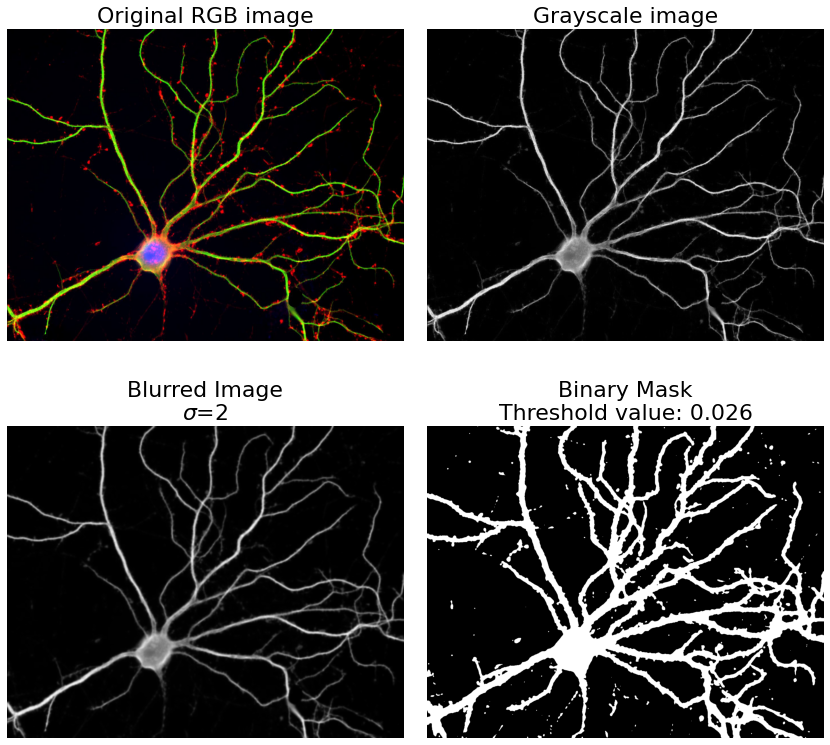

In [5]:
# Parameters
GAUSSIAN_BLUR_SIGMA = 2

# 1. Convert to a grayscale image. We obtain values between 0 and 1
img_gray = skimage.color.rgb2gray(img)

# 2. Apply a gaussian filter with a sigma of GAUSSIAN_BLUR_SIGMA
img_blur = skimage.filters.gaussian(img_gray, sigma=GAUSSIAN_BLUR_SIGMA, mode='mirror')

# 3. Compute the threshold using triangle algorithm, otsu algorithm is doing well also.
threshold = skimage.filters.threshold_triangle(img_blur)
img_threshold = img_blur > threshold

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, tight_layout=True, figsize=(12, 12))
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original RGB image', fontsize=22)
axes[0, 1].imshow(img_gray, cmap='gray')
axes[0, 1].set_title('Grayscale image', fontsize=22)
axes[1, 0].imshow(img_blur, cmap='gray')
axes[1, 0].set_title(f"Blurred Image\n$\sigma$={GAUSSIAN_BLUR_SIGMA}", fontsize=22)
axes[1, 1].imshow(img_threshold, cmap='gray')
axes[1, 1].set_title(f"Binary Mask\nThreshold value: {threshold:0.3f}", fontsize=22)
axisoff(axes)
print()

## Segmentation d'instances
Passons à un autre cas d'utilisation. Ici, nous voulons compter et caractériser le nombre d'instances dans une image. Dans notre cas, nous sommes intéressés par les cellules présentes dans cette image.

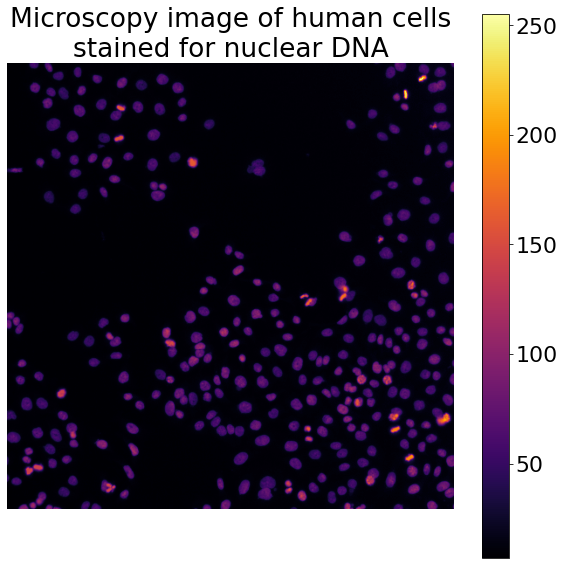

In [6]:
import tifffile

img = tifffile.imread('AS_09125_050116030001_D03f00d0.tif')

fig, ax = plt.subplots(figsize=(10, 10))
im_ax = ax.imshow(img, cmap='inferno')
fig.colorbar(im_ax)
ax.set_title('Microscopy image of human cells\nstained for nuclear DNA')
ax.axis('off')
print()

## Processing Steps
In order to count the number of cells and characterize there shape. This is not a straigforward threshold application since cells can be overlapping. Here is our plan:
1. Compute a threshold using the triangle algorithm to find the best spot to seperate the foreground from the background
2. Apply the threshold to get a binary image
3. Detect individual cells, which can be define as isolated regions. To do so, we will be using `skimage.measure.label`. More infos [here](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label). Each cell is defined by a unique label in the image.
4. We will compute the Euclidean Distance Transform on the detected cells (more [infos](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html)) which compute the distance to the nearest border for each pixel in a cell
5. From the euclidean distance transform, we can find local maxima which can be approximated as center of cells. We set that no center can be closer than MIN_DISTANCE=3 pixels.
6. Using those maxima, we will apply a watershed algorithm which will try to seperate cells masks. More [infos](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed) on the whatershed algorithm.

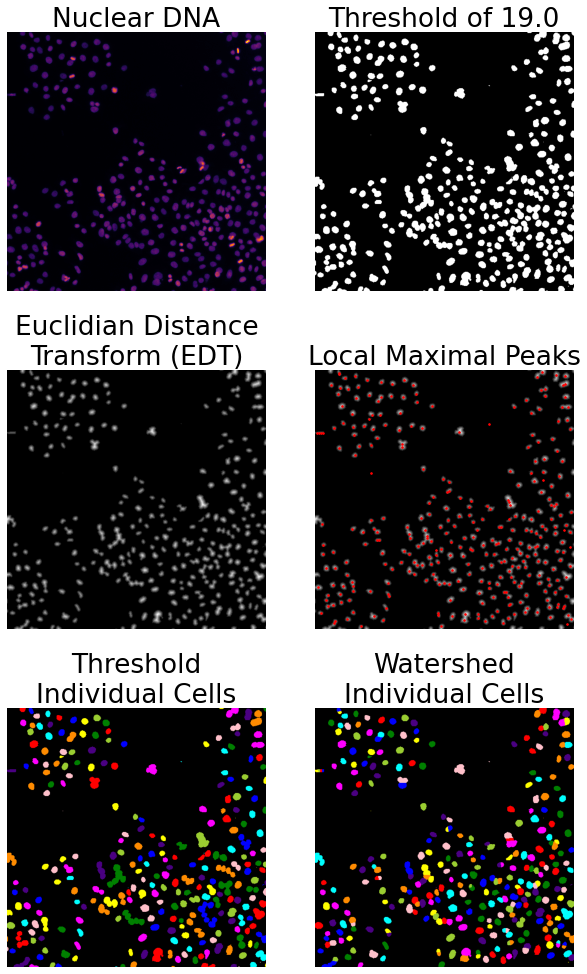

In [7]:
# Parameters
MIN_DISTANCE = 3

# 1. Compute the threshold 
threshold = skimage.filters.threshold_triangle(img)

# 2. Threshold the image with the computed threshold
cells = img > threshold

# 3. Detected individual cells
labeled_cells = skimage.measure.label(cells)
labeled_cells_rgb = skimage.color.label2rgb(labeled_cells, bg_label=0)

# 4. Compute the Euclidian
distance = scipy.ndimage.distance_transform_edt(cells)

# 5. Find local maxima
local_max_coords = skimage.feature.peak_local_max(distance, min_distance=MIN_DISTANCE)
local_max_mask = np.zeros_like(distance, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True

# 6. Using the local maxima as markers, we will apply the watershed algo
markers = skimage.measure.label(local_max_mask)
segmented_cells = skimage.segmentation.watershed(-distance, markers, mask=cells)
segmented_cells_rgb = skimage.color.label2rgb(segmented_cells, bg_label=0)

fig, axs = plt.subplots(3, 2, figsize=(10, 14), tight_layout=True)
axs[0, 0].imshow(img, cmap='inferno')
axs[0, 0].set_title('Nuclear DNA')
axs[0, 1].imshow(cells, cmap='gray')
axs[0, 1].set_title(f'Threshold of {threshold:0.1f}')
axs[2, 0].imshow(labeled_cells_rgb)
axs[2, 0].set_title('Threshold\nIndividual Cells')
axs[1, 0].imshow(distance, cmap='gray')
axs[1, 0].set_title('Euclidian Distance\nTransform (EDT)')
axs[2, 1].imshow(segmented_cells_rgb)
axs[2, 1].set_title('Watershed\nIndividual Cells')
axs[1, 1].imshow(distance, cmap='gray')
axs[1, 1].scatter(local_max_coords[:, 1], local_max_coords[:, 0], 
                  s=10, marker='.', color='r')
axs[1, 1].set_title('Local Maximal Peaks')
axisoff(axs)
print()

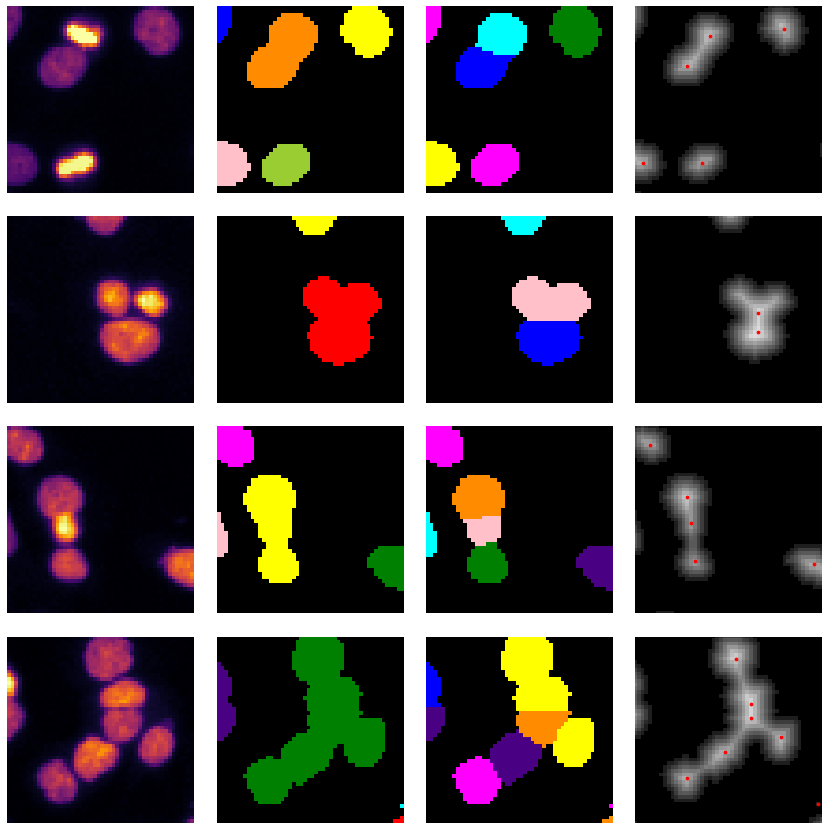

In [8]:
# Some zoomed regions
crop_height, crop_width = 50, 50
crop_corners = [
    [45, 110],
    [120, 140],
    [400, 60],
    [310, 190]
    ]
figsize = (12, 3 * len(crop_corners))
fig, axs = plt.subplots(len(crop_corners), 4, figsize=figsize, tight_layout=True)
for i, (row, col) in enumerate(crop_corners):
    slices = (slice(row, row + crop_height), slice(col, col + crop_width))
    axs[i, 0].imshow(img[slices], cmap='inferno')
    axs[i, 1].imshow(labeled_cells_rgb[slices])
    axs[i, 2].imshow(segmented_cells_rgb[slices])
    axs[i, 3].imshow(distance, cmap='gray')
    axs[i, 3].scatter(local_max_coords[:, 1], local_max_coords[:, 0], 
                  s=30, marker='.', color='r')
    axs[i, 3].set_xlim([slices[1].start, slices[1].stop])
    axs[i, 3].set_ylim([slices[0].stop, slices[0].start])
axisoff(axs)
print()

## Cell Morphological Analysis
Now that we have identified our cells in the image. We can get a bunch of charateristics them and plot them !

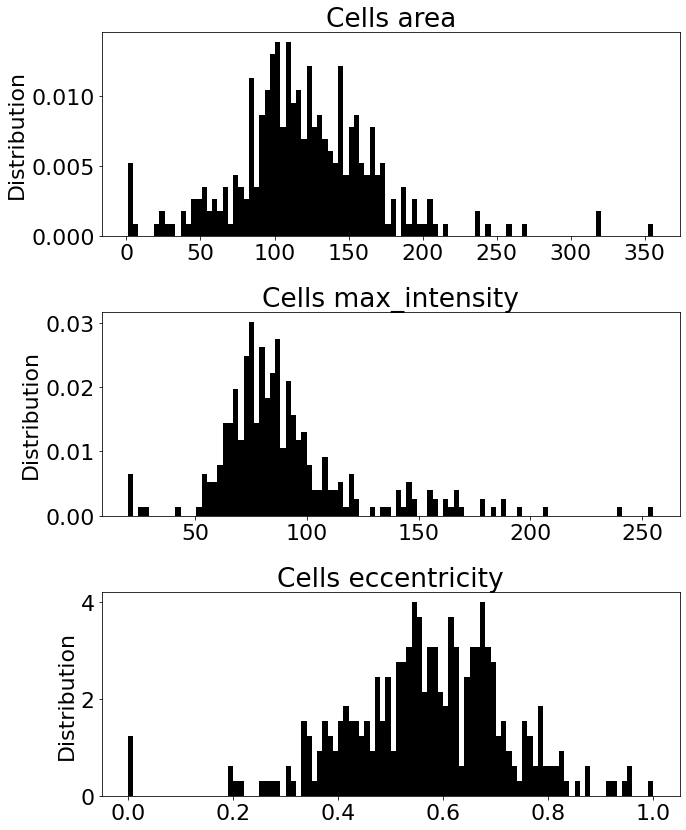

In [9]:
# Section pour manipuler les cellules individuellement
props_to_plot = ['area', 'max_intensity', 'eccentricity']
cells_props = skimage.measure.regionprops(segmented_cells, intensity_image=img)
cells_props_table = skimage.measure.regionprops_table(
    segmented_cells, 
    intensity_image=img,
    properties=props_to_plot)

props_to_plot = ['area', 'max_intensity', 'eccentricity']
figsize = (10, 4 * len(props_to_plot))
fig, axs = plt.subplots(len(props_to_plot), 1, figsize=figsize, tight_layout=True)
for ax, prop_to_plot in zip(axs, props_to_plot):
    ax.hist(cells_props_table[prop_to_plot], bins=100, color='black', density=True)
    ax.set_title(f'Cells {prop_to_plot}')
    ax.set_ylabel('Distribution')

## La convolution
La convolution est l'opération mathématique des réseaux de neurones convolutifs (CNN), le type de réseau le plus utilisé en apprentissage profond appliqué aux images. Une convolution est définie par un filtre qui est appliqué séquentiellement à des sous-sections de l'image de la même taille que le filtre. Le filtre est glissé sur l'ensemble de l'image et à chaque pas, le résultat de la convolution est la somme de la multiplication élément par élément du filtre et de la section de l'image.  

La section suivante montre, étape par étape, comment appliquer un filtre de convolution à une image. Vous pouvez modifier les paramètres pour voir l'effet sur le résultat !

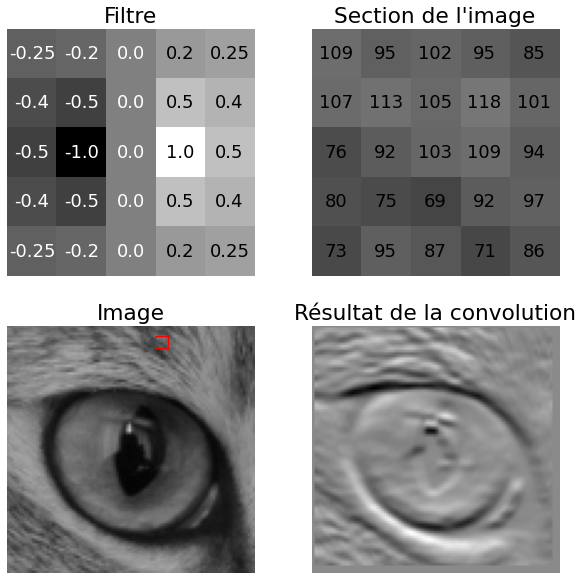

In [10]:
matplotlib.rcParams.update({'font.size': 18})

im_color = skimage.data.cat()
im = np.mean(im_color[60:160,120:220],axis=2)

###--Parameters--###
kernel_size = 5 # must be odd here
stride = 1
padding = 1
###--------------###

# Définition d'un filtre de Sobel de taille kernel x kernel
def custom_sobel(shape, axis):
    """
    shape must be odd: eg. (5,5)
    axis is the direction, with 0 to positive x and 1 to positive y
    """
    k = np.zeros(shape)
    p = [(j,i) for j in range(shape[0]) 
           for i in range(shape[1]) 
           if not (i == (shape[1] -1)/2. and j == (shape[0] -1)/2.)]

    for j, i in p:
        j_ = int(j - (shape[0] -1)/2.)
        i_ = int(i - (shape[1] -1)/2.)
        k[j,i] = (i_ if axis==0 else j_)/float(i_*i_ + j_*j_)
    return k

filter = custom_sobel((kernel_size,kernel_size),0)

feature_map_dim0 = int((im.shape[0]+2*padding-(kernel_size-1)-1)/stride + 1)
feature_map_dim1 = int((im.shape[1]+2*padding-(kernel_size-1)-1)/stride + 1)

# Result that builds iteratively
conv_result = np.zeros((feature_map_dim0+2*padding,feature_map_dim1+2*padding))

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(filter,cmap='gist_gray')
for xx in range(filter.shape[0]):
  for yy in range(filter.shape[1]):
    if filter[xx,yy]>0:
      color = 'k'
    else:
      color = 'w'
    ax[0,0].text(yy,xx,s=filter[xx,yy],color=color,horizontalalignment='center',verticalalignment='center')
ax[0,0].set_title('Filtre')
ax[1,1].set_title('Résultat de la convolution')

for axi in ax.ravel():
	axi.axis('off')

time_limit = 30
time_before = time.time()
for i in range(feature_map_dim0-int(2*padding/stride)):
  for j in range(feature_map_dim1-int(2*padding/stride)):
    conv_result[i+padding,j+padding] = np.sum(np.matmul(filter, im[stride*i:stride*i+kernel_size, stride*j:stride*j+kernel_size]))
    # update display only every N steps, otherwise it is too slow
    if time.time()-time_before<time_limit:
      if j % 10 == 0:
        ax[1,0].cla()
        ax[1,0].imshow(im, cmap='gist_gray', vmin=0, vmax=255)
        ax[1,0].axis('off')
        conv = matplotlib.patches.Rectangle((-0.5+stride*j,-0.5+stride*i), width=kernel_size, height=kernel_size, linewidth=1, edgecolor='r', facecolor='none')
        ax[1,0].add_patch(conv)
        ax[1,0].set_title('Image')
        
        im_section = im[stride*i:stride*i+kernel_size, stride*j:stride*j+kernel_size]
        ax[0,1].cla()
        ax[0,1].imshow(im_section, cmap='gist_gray',vmin=0,vmax=255)
        ax[0,1].set_title('Section de l\'image')
        ax[0,1].axis('off')
        for xx in range(filter.shape[0]):
          for yy in range(filter.shape[1]):
            ax[0,1].text(yy,xx,s=im_section[xx,yy].astype(int),color=color,horizontalalignment='center',verticalalignment='center')

        ax[1,1].imshow(conv_result, cmap='gist_gray')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)

ax[1,1].imshow(conv_result, cmap='gist_gray')




## Convolution parameters

The convolution is defined by 4 main parameters:

- Kernel size: The size, in pixels, of one side of the filter. Although it is possible to apply a convolution with a non-square filter, it is generally the geometry that is used in the CNN.
- Stride: The displacement in pixels between each operation
- Padding: As long as the filter has a size greater than 1x1, the result of the convolution will have a size smaller than the original image. A padding on the border of the image is often added so that the result has the same size as the original image.
- Dilation: The spacing between pixels in the section of the image to which the filter is applied.

These parameters are presented visually in the next section.

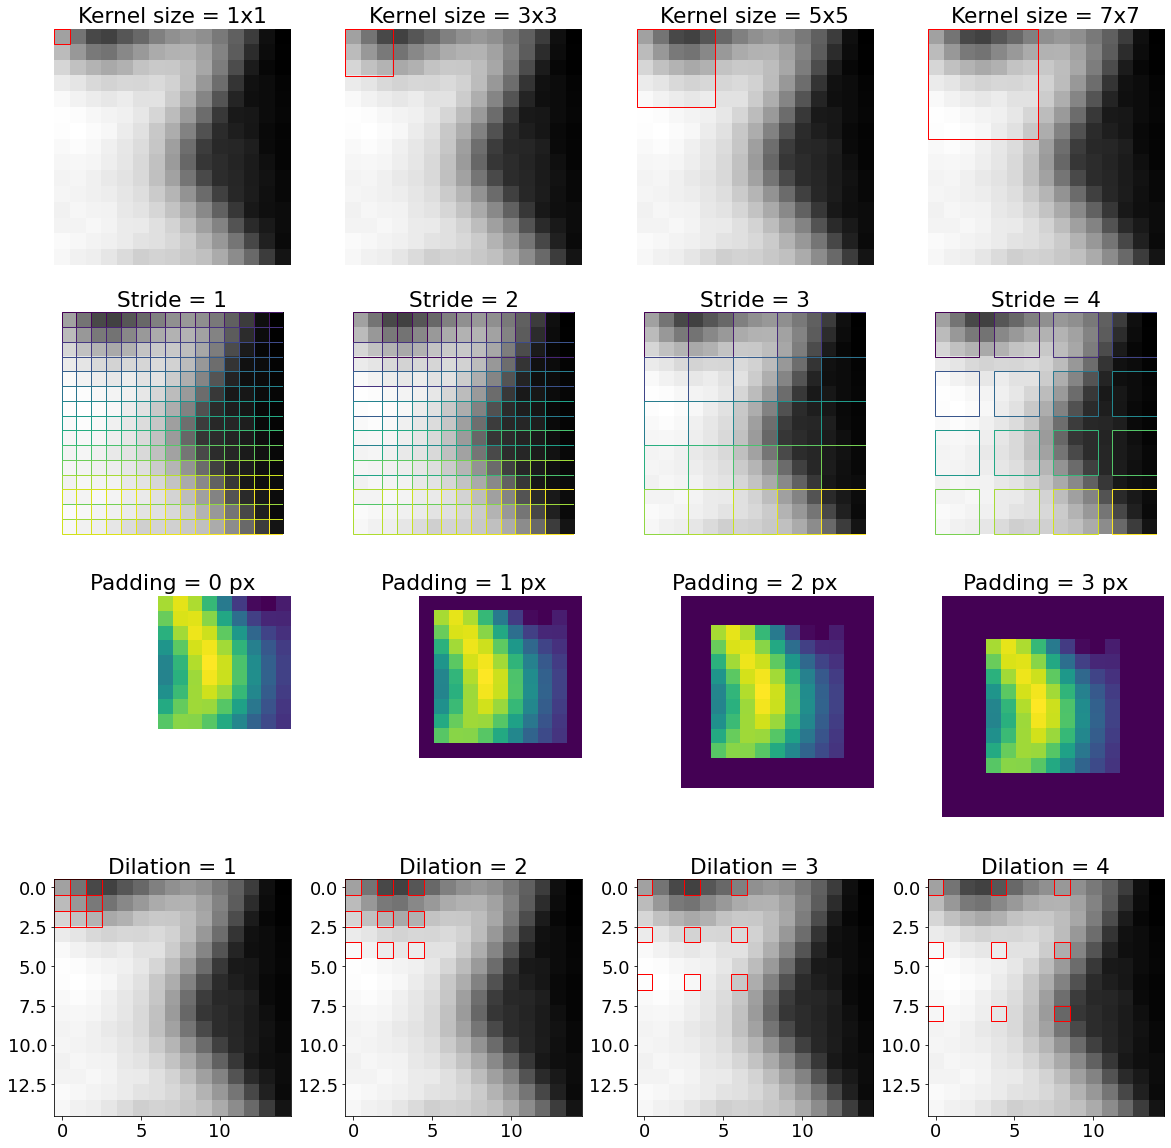

In [11]:
crop_size = 15
im = np.mean(skimage.data.astronaut(),axis=2)[:crop_size,:crop_size]

#---Kernel size---#
kernel_size_list = [1,3,5,7]
#-----------------#

fig, axs = plt.subplots(4,4,figsize=(20,20))

for ax, kernel_size in zip(axs[0].ravel(), kernel_size_list):
  ax.imshow(im,cmap='gist_gray')
  filter = matplotlib.patches.Rectangle((-0.5,-0.5), width=kernel_size, height=kernel_size, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(filter)
  ax.axis('off')
  ax.set_ylim(14.5,-0.5)
  ax.set_title('Kernel size = {}x{}'.format(kernel_size,kernel_size))

#---Stride---#
stride_list = [1,2,3,4]
#------------#

for ax, stride in zip(axs[1].ravel(), stride_list):
  color_idx = 0
  color_range = len(range(0,im.shape[0]-2,stride))*len(range(0,im.shape[1]-2,stride))
  viridis = matplotlib.cm.get_cmap('viridis', color_range)
  ax.imshow(im, cmap='gist_gray')
  for i in range(0,im.shape[0]-2,stride):
    for j in range(0,im.shape[1]-2,stride):
      filter = matplotlib.patches.Rectangle((j-0.5,i-0.5), width=3, height=3, linewidth=1, edgecolor=viridis(color_idx), facecolor='none')
      color_idx += 1/color_range
      ax.add_patch(filter)
  ax.axis('off')
  ax.set_ylim(15.5,-0.5)
  ax.set_title('Stride = {}'.format(stride))

#---Padding---#
padding_list = [0,1,2,3]
#-------------#

filter = custom_sobel((7,7), 0)
conv_result = scipy.signal.convolve2d(im, filter, mode='valid')

for ax, padding in zip(axs[2].ravel(), padding_list):
  conv_result_padded = np.pad(conv_result, padding)
  ax.imshow(conv_result_padded, cmap='viridis')
  ax.set_ylim(15.5,-0.5)
  ax.set_xlim(15.5,-0.5)
  ax.set_title('Padding = {} px'.format(padding))
  ax.axis('off')

#---Dilation---#
dilation_list = [1,2,3,4]
#--------------#

for ax, dilation in zip(axs[3].ravel(), dilation_list):
  ax.imshow(im, cmap='gist_gray')
  for i in range(3):
    for j in range(3):
      px = matplotlib.patches.Rectangle((j-0.5+j*(dilation-1),i-0.5+i*(dilation-1)), width=1, height=1, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(px)
  ax.set_title('Dilation = {}'.format(dilation))

plt.show()


# Why do we use convolution?

Convolution filters are used to highlight image features that span multiple pixels. The result of a convolution applied to an image is called a feature map. Feature maps will indicate the locations in the image that contain the element of interest defined by the filter: a circle, a straight vertical line, a point, etc. By applying several filters one after the other, the highlighted elements can become more complex: an eye, a cat's ear, a car wheel, etc.

The following code section shows the result of a simple filter, the Sobel filter, which allows you to highlight the horizontal, vertical and diagonal borders of an image.

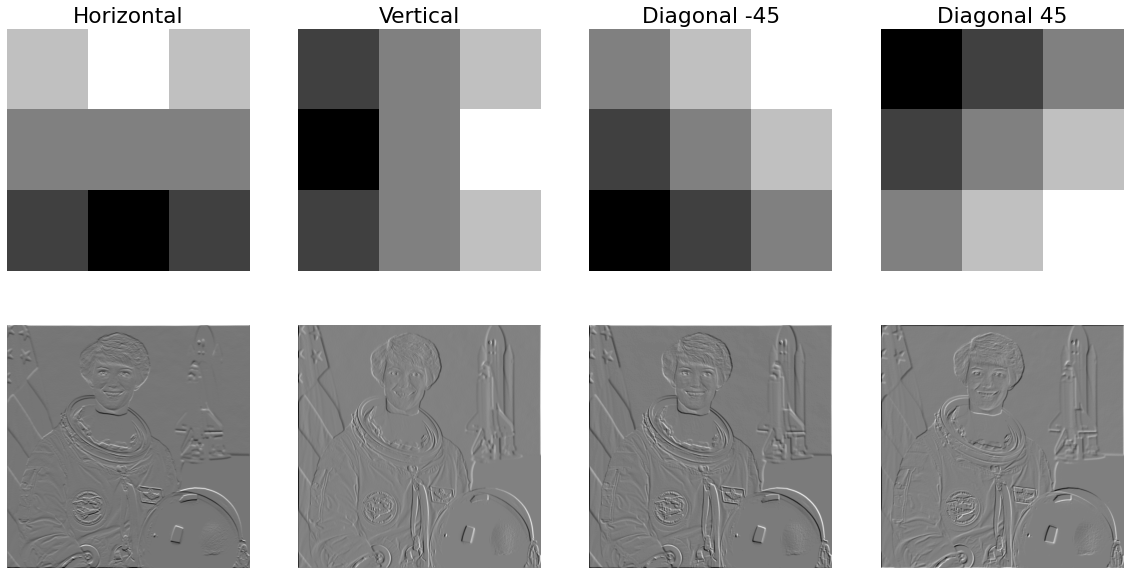

In [12]:
fig, axs = plt.subplots(2,4,figsize=(20,10))
im = np.mean(skimage.data.astronaut(),axis=2)

sobel_horizontal = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
sobel_vertical = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
sobel_diagonal1 = np.array([[0,1,2], [-1,0,1], [-2,-1,0]])
sobel_diagonal2 = np.array([[-2,-1,0], [-1,0,1], [0,1,2]])

filter_list = [sobel_horizontal, sobel_vertical, sobel_diagonal1, sobel_diagonal2]
filter_name_list = ['Horizontal', 'Vertical', 'Diagonal -45', 'Diagonal 45']

for idx, filter in enumerate(filter_list):
  axs[0,idx].imshow(filter, cmap='gist_gray')
  axs[1,idx].imshow(scipy.signal.convolve2d(im,filter), cmap='gist_gray')
  axs[0,idx].set_title(filter_name_list[idx])
  axs[0,idx].axis('off')
  axs[1,idx].axis('off')

plt.show()

# Apprentissage profond appliqué aux images

## Réseau de neurones à convolution / Convolution neural network (CNN) 

Le réseau neuronal à convolution applique séquentiellement des convolutions à une image. Le nombre d'opérations par couche, le nombre de couches et les paramètres de la convolution sont fixes, mais les poids et les biais des convolutions sont appris lors de la formation.

La section de code suivante illustre l'apprentissage de ces poids et biais en comparant des filtres de convolution AlexNet initialisés de manière aléatoire et ces mêmes filtres après formation. 

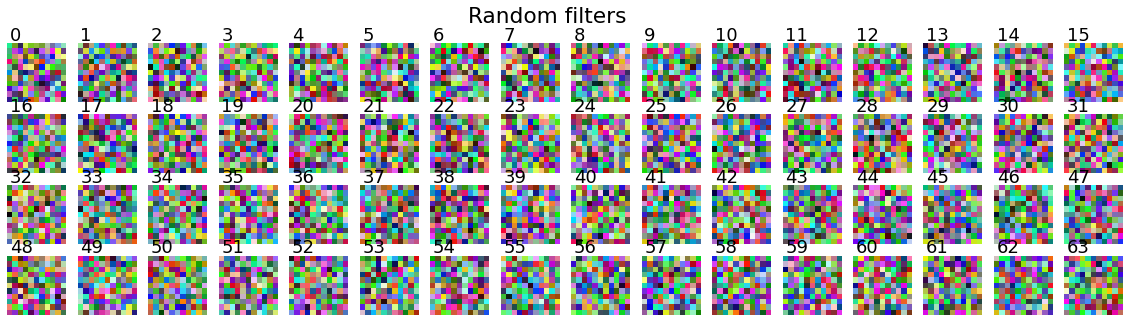

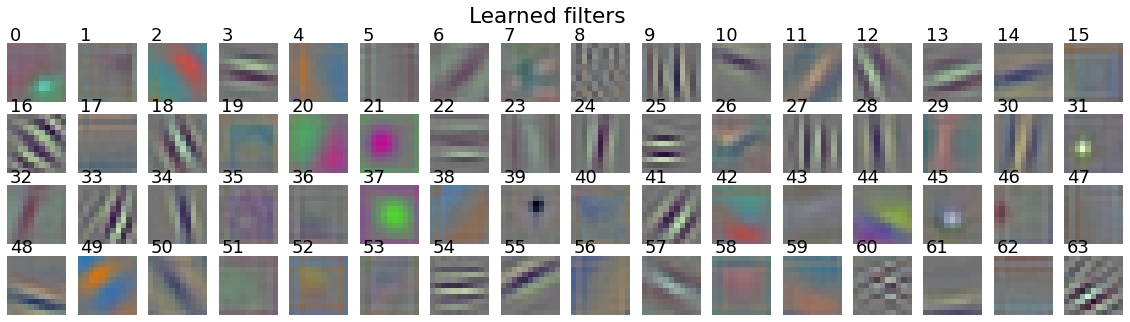

In [13]:
def plot_weights(model, layer_num, title=""):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data

    #normalize weight_tensor between 0 and 1.0 for visualization
    weight_tensor = ((weight_tensor-weight_tensor.min()) / (weight_tensor.max()-weight_tensor.min()) * 1.0)

    #switch order of channels to fit with matplotlib (torch uses CxHxW, matplotlib uses HxWxC)
    weight_tensor = weight_tensor.permute(0,2,3,1)
    
    fig, axs = plt.subplots(4,16, figsize=(20,5)) # we stop at 64 filters
    for idx in range(min(weight_tensor.shape[0],64)):
      axs.ravel()[idx].imshow(weight_tensor[idx])
      axs.ravel()[idx].text(0,-1,s=str(idx))
      axs.ravel()[idx].axis('off')
    plt.suptitle(title)
    plt.show()        
  else:
    print("Can only visualize layers which are convolutional")
        
#visualize weights for alexnet - first convolution 
alexnet = models.alexnet(pretrained=False)
plot_weights(alexnet, 0, title="Random filters")
alexnet_trained = models.alexnet(pretrained=True)
plot_weights(alexnet_trained, 0, title="Learned filters")

Maintenant, visualisons le résultat de ces filtres appliqués sur une image! On remarque bien qu'un filtre aléatoire ne met pas en valeur d'éléments précis, mais les filtres appris font ressortir des éléments de base comme les lignes, les ronds, les motifs quadrillés, etc.

Changez la variable "filtre_idx" pour appliquer le filtre de votre choix, en référence aux numéros de filtre de la cellule précédente.

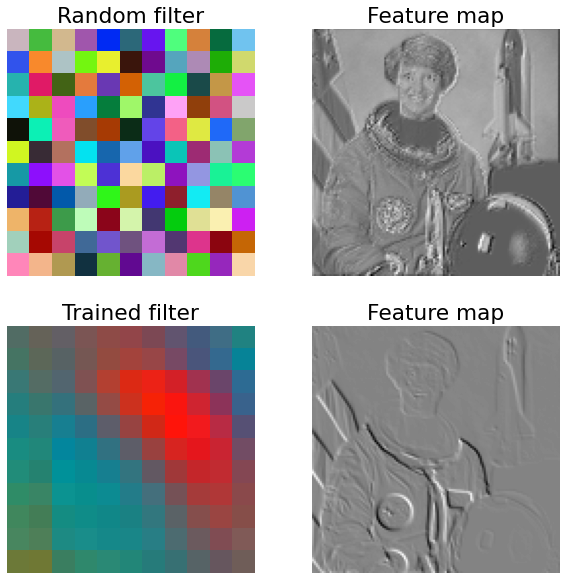

In [14]:
#---Choose the filter to apply [0,63]--#
filter_idx = 2 
#--------------------------------------#

# Image
im = torch.tensor(skimage.data.astronaut()).unsqueeze(0)
im = im.permute(0,3,1,2).float()

# Aplly first convolution layer from AlexNet to image
im_conv_nottrained = alexnet.features[:1](im)
im_conv_trained = alexnet_trained.features[:1](im)

fig, axs = plt.subplots(2,2,figsize=(10,10))

# Random filter
filter_nottrained = alexnet.features[0].weight[filter_idx].permute(1,2,0).detach().numpy()
filter_nottrained = (filter_nottrained-filter_nottrained.min())/(filter_nottrained.max()-filter_nottrained.min())
axs[0,0].imshow(filter_nottrained)
axs[0,0].set_title('Random filter')
axs[0,1].imshow(im_conv_nottrained[0,filter_idx,...].detach().numpy(),cmap='gist_gray')
axs[0,1].set_title('Feature map')

# Trained filter
filter_trained = alexnet_trained.features[0].weight[filter_idx].permute(1,2,0).detach().numpy()
filter_trained = (filter_trained-filter_trained.min())/(filter_trained.max()-filter_trained.min())
axs[1,0].imshow(filter_trained)
axs[1,0].set_title('Trained filter')
axs[1,1].imshow(im_conv_trained[0,filter_idx,...].detach().numpy(),cmap='gist_gray')
axs[1,1].set_title('Feature map')

for ax in axs.ravel():
  ax.axis('off')

(-0.5, 511.5, 511.5, -0.5)

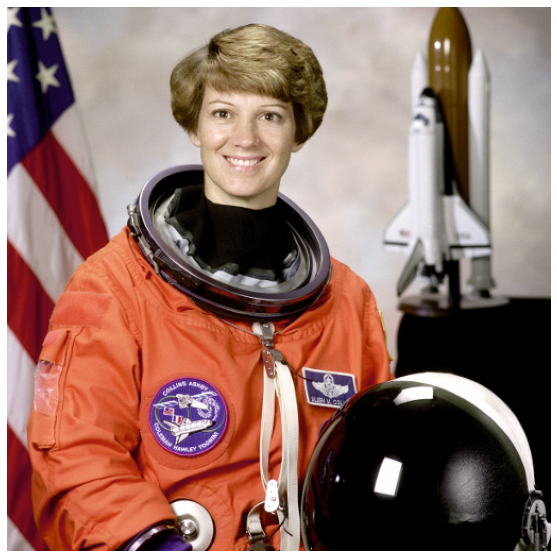

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(skimage.data.astronaut())
ax.axis('off')

Text(50, 85, 'Lip?')

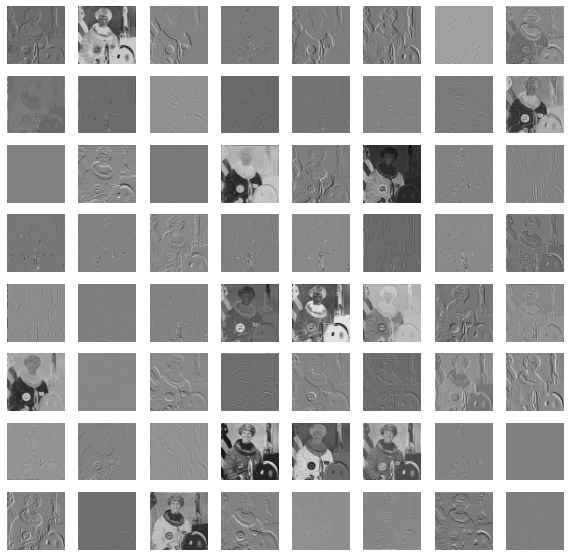

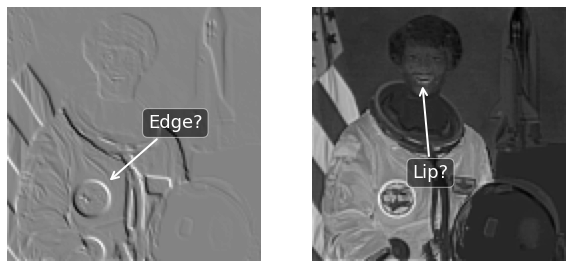

In [16]:
# Display all feature maps from first convolution layer of AlexNet

fig, axs = plt.subplots(8,8,figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
  ax.imshow(im_conv_trained[0,i,...].detach().numpy(),cmap='gist_gray')
  ax.axis('off')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, to_show) in enumerate(zip(axs, (2, 21))):
  ax.imshow(im_conv_trained[0, to_show].detach(), cmap='gist_gray')
  ax.axis('off')
axs[0].annotate('Edge?', (50, 87), (70, 60), 
                color='w',
                arrowprops={'arrowstyle':'->', 'linewidth': 2, 'color':'w'},
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='w', boxstyle='round'))
axs[1].annotate('Lip?', (55, 38), (50, 85), 
                color='w',
                arrowprops={'arrowstyle':'->', 'linewidth': 2, 'color':'w'},
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='w', boxstyle='round'))

Exemples d'images qui activent ces filtres:

<img src="https://media5.datahacker.rs/2021/11/image-70.png">

<img src="https://media5.datahacker.rs/2021/11/image-71-1024x496.png">

Source : [PyTorch – Visualization of Convolutional Neural Networks in PyTorch](https://datahacker.rs/028-visualization-and-understanding-of-convolutional-neural-networks-in-pytorch/)

## Apprentissage des filtres

<img src="https://www.researchgate.net/publication/331540139/figure/fig4/AS:733273504354306@1551837435967/The-overall-architecture-of-the-Convolutional-Neural-Network-CNN-includes-an-input.png" width="800" align="center"/>

Les valeurs des filtres du réseau de convolution sont apprises en comparant la sortie du réseau à la vérité terrain. La *vérité terrain* est constituée par les étiquettes créées manuellement par un expert a priori de la formation du réseau (formation supervisée).

Dans la cellule de code suivante, nous pouvons visualiser les filtres appris par un réseau. En augmentant la variable **cnn_layer** pour visualiser les couches plus profondes du réseau, nous pouvons clairement observer que les caractéristiques mises en évidence par les filtres deviennent plus complexes par l'application de plusieurs filtres en cascade. A l'inverse, pour les premières couches du réseau, les caractéristiques sont beaucoup plus simples.

Ici, le réseau est déjà entraîné, nous n'optimisons donc pas ses poids. Au contraire, nous optimisons l'image d'entrée pour maximiser l'activation du filtre choisi. Pour plus d'informations, je vous recommande absolument de consulter la source de la méthode : [How to visualize convolutional features in 40 lines of code](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030). 


Iteration: 0 Loss: -26.81
Iteration: 1 Loss: -94.99
Iteration: 2 Loss: -150.40
Iteration: 3 Loss: -201.89
Iteration: 4 Loss: -228.54


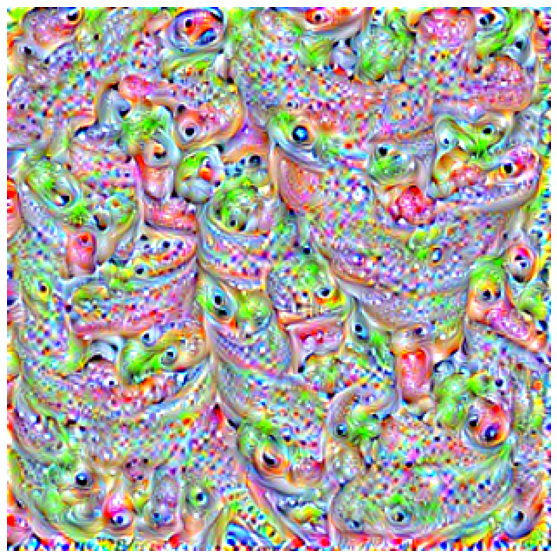

In [17]:
# Source: https://github.com/utkuozbulak/pytorch-cnn-visualizations
# Source: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        sz = 128
        random_image = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        for j in range(5): # Increase the number of iterations to get a better resolution (but requires more computing time)
          # Define optimizer for the image
          optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
          for i in range(1, 11):
              optimizer.zero_grad()
              # Assign create image to a variable to move forward in the model
              x = processed_image
              for index, layer in enumerate(self.model):
                  # Forward pass layer by layer
                  # x is not used after this point because it is only needed to trigger
                  # the forward hook function
                  x = layer(x)
                  # Only need to forward until the selected layer is reached
                  if index == self.selected_layer:
                      # (forward hook function triggered)
                      break
              # Loss function is the mean of the output of the selected layer/filter
              # We try to minimize the mean of the output of that specific filter
              loss = -torch.mean(self.conv_output)
              # Backward
              loss.backward()
              # Update image
              optimizer.step()
          print('Iteration:', str(j), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
          # Rescale image by factor 1.2
          sz = int(1.2 * sz)
          processed_image = processed_image.detach().numpy()
          processed_image = processed_image[0].transpose(1,2,0)
          processed_image = cv2.resize(processed_image, (sz, sz), interpolation = cv2.INTER_CUBIC)
          processed_image = torch.tensor(processed_image).permute(2,0,1).unsqueeze(0)
          processed_image.requires_grad = True
        # Recreate image
        self.created_image = recreate_image(processed_image)
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        ax.imshow(self.created_image)
        ax.axis('off')

#---Paramètres---#
# La complexité des filtres augmente avec la prodondeur de la convolution (cnn_layer)
cnn_layer = 24 # choose between 0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24
filter_pos = 29 # [0,63] if cnn_layer = (0,2), [0,127] if cnn_layer = (5,7), [0,255] if cnn_layer = (10,12,14), [0,511] otherwise
#----------------#

# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()


Pour plus d'exemples et l'explication du fonctionnement: [How to visualize convolutional features in 40 lines of code](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030)

<table><tr>
<td> <img src="https://miro.medium.com/max/276/1*sLZBebq-3QjUSchP8Sn2Kg.jpeg" width="500"/></td>
<td> <img src="https://miro.medium.com/max/408/1*kME_uQu_elNyNfgTY-7xpQ.jpeg" width="500"/> </td>
<td> <img src="https://miro.medium.com/max/408/1*MznCLV-oe3_HAXzbojw-zg.jpeg" width="500"/> </td>
<td> <img src="https://miro.medium.com/max/408/1*A8-RygaInWt8LBHXO7H05Q.jpeg" width="500"/> </td>
<td> <img src="https://miro.medium.com/max/408/1*JcWSiiLzvNDQB7rIAgTYlg.jpeg" width="500"/> </td>
</tr></table>

Et : [PyTorch – Visualization of Convolutional Neural Networks in PyTorch](https://datahacker.rs/028-visualization-and-understanding-of-convolutional-neural-networks-in-pytorch/)
<img src="https://lh3.googleusercontent.com/d3E0XDAj-HDQy1r39CJvo0-0PZrVzCVBh0zY9kRJt02W4tEyQus0_je35znoaulR9k4VWeO4LJxMsdUD5imZajwPBOjvacH845ff7HhRqCrog9FbnAdlKMECzBwo1dcitzdtO1Hf">

### Gradient activation view
When a network has been trained, a naive way to see what the network is looking when making a prediction is to look at the gradient values for the specific class.

--2022-03-23 14:35:23--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.5’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-03-23 14:35:23 (26.9 MB/s) - ‘imagenet_classes.txt.5’ saved [10472/10472]



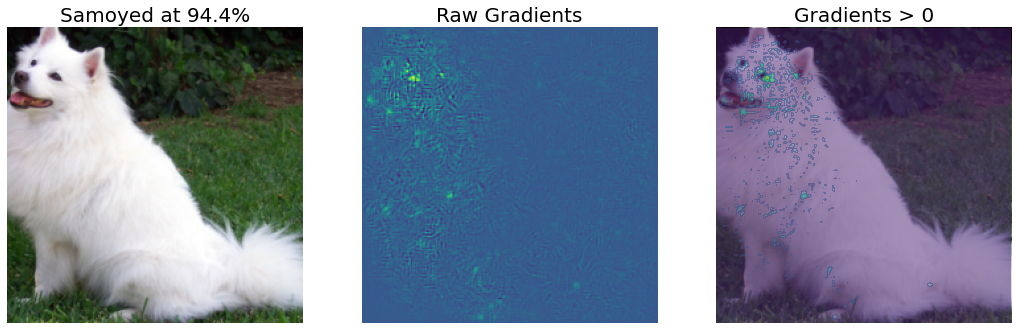

In [18]:
matplotlib.rcParams.update({'font.size': 20})

torch.manual_seed(42)

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Load a dog image from pytorch site

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

# Dog image in the range 0 - 255
dog = Image.open(filename)

# Define image transformations
alexnet_stats = {
    'mean': [0.485, 0.456, 0.406], 
    'std': [0.229, 0.224, 0.225]
} # see https://pytorch.org/hub/pytorch_vision_alexnet/
reshape = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**alexnet_stats),
])

# Reshape the dog image to 224x224
dog = reshape(dog)
reshaped_dog = dog.copy()
# Normalize the intensity value of the dog image
dog = normalize(dog)
dog = dog.unsqueeze(0) # Create a mini-batch of 1 element

# Set the dog image to require gradients
dog.requires_grad = True

# Apply AlexNet to get a prediction on the image
output = alexnet_trained(dog)[0]

# ouput is a Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores (not between 0 and 1). 
# To get probabilities, we will run a softmax on it.
probabilities = torch.nn.functional.softmax(output, dim=0)

# We will get the indice with the highest probability
highest_probability_indice = torch.argmax(output)

# From that indice, we can retreive the predicted categorie 
predicted_category = categories[highest_probability_indice]

# We will also retrieve the probability the network gave to this category
predicted_probability = probabilities[highest_probability_indice]

# Since we set the input image to require gradients, we can backprogated
# the gradients associated to the highest category to get a glimpse of which 
# are influencing the prediction the most
output[highest_probability_indice].backward()
gradients = dog.grad.squeeze(0).numpy()
gradients = np.max(gradients, axis=0)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=((18, 6)))
axs[0].imshow(reshaped_dog)
axs[0].set_title(f'{predicted_category} at {predicted_probability*100:.1f}%', fontsize=20)
axs[1].imshow(gradients, cmap='viridis')
axs[1].set_title('Raw Gradients', fontsize=20)
axs[2].imshow(reshaped_dog)

# Get a smoothed density map
x = np.arange(0, 224)
X, Y = np.meshgrid(x, x)
gradients[gradients < 0] = 0
axs[2].contourf(X, Y, gradients, alpha=0.5, levels=5)
axs[2].set_title('Gradients > 0', fontsize=20)

for ax in axs:
    ax.axis('off')

(-0.5, 223.5, 223.5, -0.5)

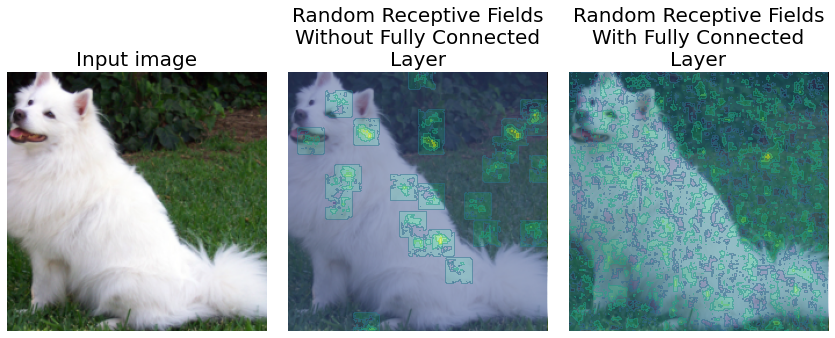

In [19]:
# Create a simple convolutional network without a final classification layer
def simple_network(classification_layer=False):
    modules = []
    modules.extend([
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.AvgPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.AvgPool2d(2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.AvgPool2d(2),
        nn.Flatten()
    ])
    if classification_layer:
        modules.append(nn.Linear(32 * 28 * 28, 10))
    return nn.Sequential(*modules)

fig, axs = plt.subplots(1, 3, figsize=((12, 6)), tight_layout=True)
for ax_id, classification_layer, n_samples in zip([1, 2], [False, True], [25, 1]):

    # Taking the dog example again, we set gradients to zero
    dog.grad.zero_()

    # Foward pass in our simple network
    net = simple_network(classification_layer=classification_layer)
    output = net(dog)[0]

    # Random receptive activations
    for indice in np.random.randint(0, output.size(), n_samples):
        output[indice].backward(retain_graph=True)

    # Max out gradients over RGB channels
    gradients = dog.grad.squeeze(0).numpy()
    gradients = np.max(gradients, axis=0)

    # Plotting

    axs[ax_id].imshow(reshaped_dog)

    # Get a smoothed density map
    x = np.arange(0, 224)
    X, Y = np.meshgrid(x, x)
    axs[ax_id].contourf(X, Y, gradients, alpha=0.5, levels=5)
    with_without = 'With' if classification_layer else 'Without'
    axs[ax_id].set_title(f'Random Receptive Fields\n{with_without} Fully Connected\nLayer', fontsize=20)
    axs[ax_id].axis('off')

axs[0].imshow(reshaped_dog)
axs[0].set_title('Input image', fontsize=20)
axs[0].axis('off')

## Couches de *Pooling*

<img src="https://production-media.paperswithcode.com/methods/MaxpoolSample2.png">

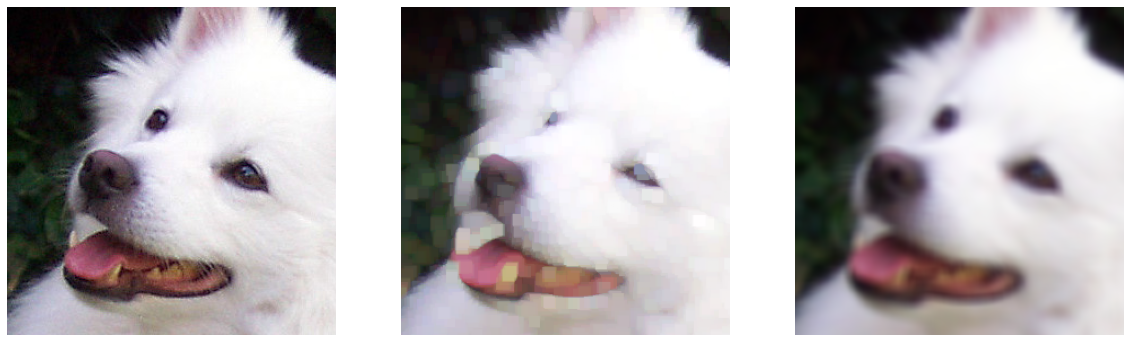

In [20]:
#--Parameters--#
kernel = 10
stride = 1
random_input = False
#--------------#

if random_input:
    # Random input
    input = torch.randn(1, 1, 100, 100)
else:
    # Or, load a dog image from pytorch site
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
    urllib.request.urlretrieve(url, filename)

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Convert the dog PIL image to Torch tensor
    dog = Image.open(filename)
    dog = transform(dog)

    # Crop it's cute face
    input = dog[:,100:400,200:500]

# Max Pooling
m = nn.MaxPool2d(kernel, stride=stride)
output_m = m(input)

# Mean Pooling
a = nn.AvgPool2d(kernel, stride=stride)
output_a = a(input)

# Display
fig, axs = plt.subplots(1,3,figsize=(20,10))
if not random_input:
    input = input.transpose(0,2).transpose(0,1)
    output_a = output_a.transpose(0,2).transpose(0,1)
    output_m = output_m.transpose(0,2).transpose(0,1)
    
axs[0].imshow(input.squeeze())
axs[1].imshow(output_m.squeeze())
axs[2].imshow(output_a.squeeze())

for ax in axs:
    ax.axis('off')

# Appplications

## Segmentation d'images naturelles
<img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2020/07/u-net-segmentation-e1542978983391.png">

## Segmentation d'images médicales

Using cache found in /home/catherine/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


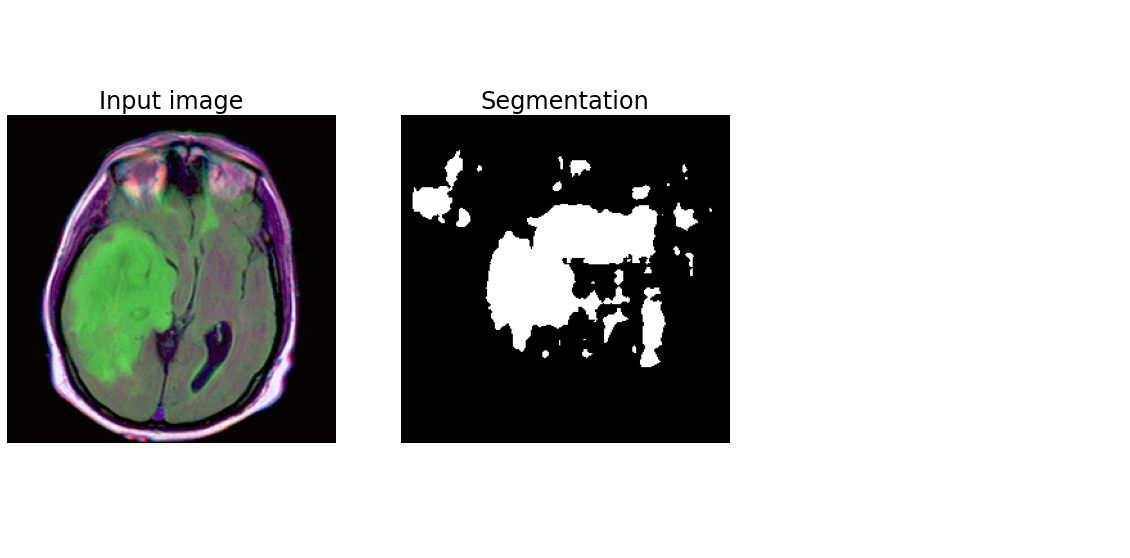

In [21]:
## Source : https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
    
import numpy as np
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if 0:#torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')
    
with torch.no_grad():
    output = model(input_batch)

fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(input_image)
ax[0].set_title('Input image')
ax[1].imshow(torch.round(output[0][0]).cpu().numpy(),cmap='gist_gray')
ax[1].set_title('Segmentation')

for a in ax:
    a.axis('off')

#### **Segmentation**
Dans une tâche de segmentation, nous sommes intéressés par la classification de tous les pixels d'une image d'entrée.

Pour ce faire, tout comme pour la tâche de classification, la première section est utilisée pour l'extraction de caractéristiques. Celles-ci permettent au réseau de projeter l'image d'entrée dans un espace de caractéristiques abstrait. A partir de cet espace, des opérations sont effectuées pour revenir à l'espace d'origine, afin d'obtenir une représentation spatiale de ce que le réseau a détecté dans l'image d'origine. 

Voici un exemple d'un tel réseau.
<img src='https://raw.githubusercontent.com/mateuszbuda/brain-segmentation-pytorch/master/assets/unet.png' width=500px>

## Classification


<img src='https://d2l.ai/_images/resnet18.svg'>

In [22]:
net = torchvision.models.resnext50_32x4d(pretrained=True)

def load_dataset(path,shuffle=True,batch_size=8):
    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(),
        normalize])
    
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform=transform
    )
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return train_loader    

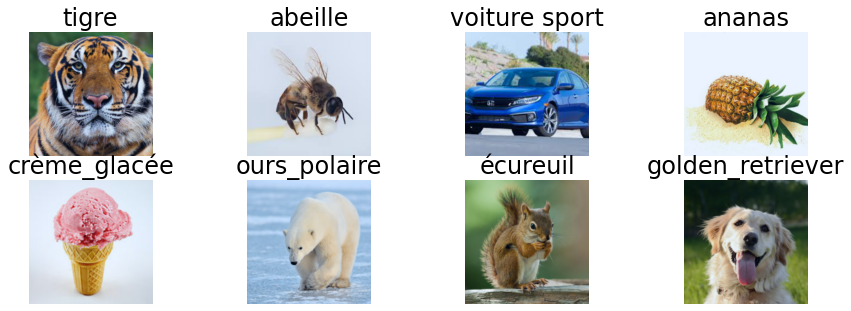

In [23]:
# Bons exemples 
net.eval()

import json
class_idx = json.load(open('imagenet_class_index.json'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

fig, axs = plt.subplots(2,4,figsize=(15,5))
for batch_idx, (data, target) in enumerate(load_dataset('images/')):
    output = net(data)
    for i in range(8):
        im = data[i].permute(1,2,0)
        im = im-im.min()
        im = im/im.max()
        axs.ravel()[i].imshow(im)
        axs.ravel()[i].set_title(idx2label[output[i].argmax()])
        axs.ravel()[i].axis('off')
    break

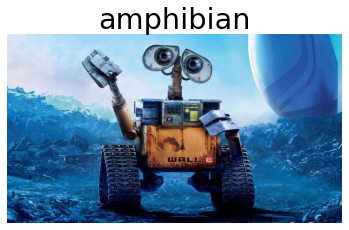

In [24]:
# On peut le tester sur n'importe quoi!
image = os.listdir('nimporte_quoi/image')[0]
image = Image.open(os.path.join('nimporte_quoi/image',image))
plt.rcParams.update({'font.size': 24})
for batch_idx, (data, target) in enumerate(load_dataset('nimporte_quoi',shuffle=False, batch_size=1)):
    output = net(data)
    fig, axs = plt.subplots(1,1)
    axs.imshow(image)
    axs.set_title(idx2label[output[0].argmax()])
    axs.axis('off')
    break
plt.rcParams.update({'font.size': 16})

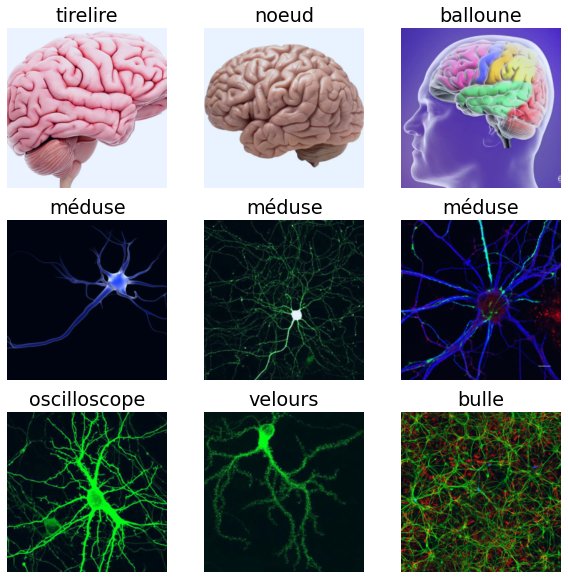

In [25]:
# Mauvais exemples
for batch_idx, (data, target) in enumerate(load_dataset('images_nottrained',shuffle=False, batch_size=9)):
    output = net(data)
    fig, axs = plt.subplots(3,3,figsize=(10,10))
    for i in range(9):
        im = data[i].permute(1,2,0)
        im = im-im.min()
        im = im/im.max()
        axs.ravel()[i].imshow(im)
        axs.ravel()[i].set_title(idx2label[output[i].argmax()])
        axs.ravel()[i].axis('off')
    break

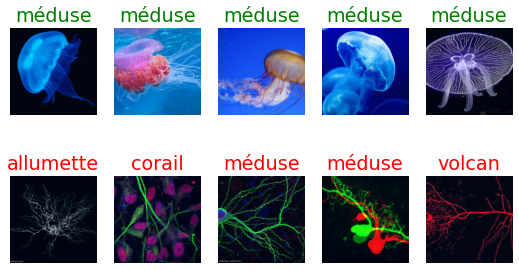

In [26]:
# Le réseau ne fait pas la différence entre des neurones et des méduses!
fig, axs = plt.subplots(2,5,figsize=[9,5])
for batch_idx, (data, target) in enumerate(load_dataset('test_meduses_neurones',shuffle=False,batch_size=10)):
    pred = net(data)
    for i in range(10):
        im = data[i].permute(1,2,0)
        im = im-im.min()
        im = im/im.max()
        axs.ravel()[i].imshow(im)
        if pred[i].argmax() == 107 and target[i] == 0:
            color = 'g'
        else:
            color = 'r'
        axs.ravel()[i].set_title(idx2label[pred[i].argmax()],color=color)
        axs.ravel()[i].axis('off')
    break

Training accuracy @ epoch 0 : 34.4%
Training accuracy @ epoch 1 : 90.6%
Training accuracy @ epoch 2 : 96.9%


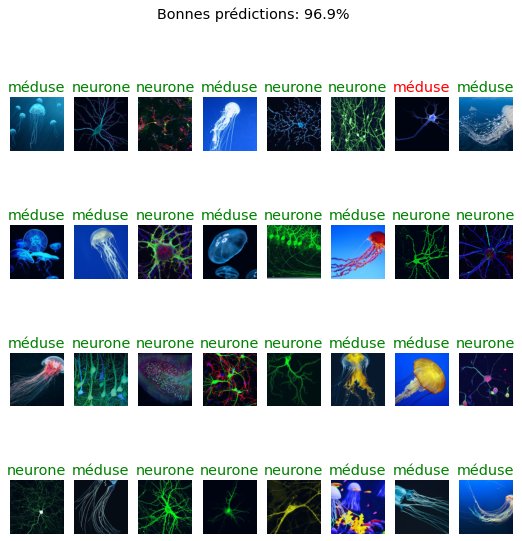

In [27]:
# On va apprendre à un réseau à différencier des méduses et des neurones!
target_index = ['méduse', 'neurone']

for param in net.parameters():
    param.requires_grad = False

# Modification du réseau pour 2 classes
num_ftrs = net.fc.in_features
net2 = net
net2.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_conv = torch.optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

fig, ax = plt.subplots(4,8,figsize=[9,9])
plt.rcParams.update({'font.size': 12})
for epoch in range(3):
    j, good_preds = 0, 0
    for batch_idx, (data, target) in enumerate(load_dataset('images_meduses_neurones',shuffle=True)):
        pred = net2(data)
        loss = criterion(pred, target)
        optimizer_conv.zero_grad()
        loss.backward()
        optimizer_conv.step()
        for i in range(8):
            im = data[i].permute(1,2,0)
            im = im - im.min()
            im = im / im.max()
            ax[j,i].imshow(im)
            ax[j,i].axis('off')
            if pred[i].argmax() == target[i]:
                color = 'g'
                good_preds += 1
            else:
                color = 'r'
            ax[j,i].set_title('{}'.format(target_index[pred[i].argmax()]),color=color)
        j += 1
    print('Training accuracy @ epoch {} : {:.1f}%'.format(epoch, good_preds/32*100))
    plt.suptitle('Bonnes prédictions: {:.1f}%'.format(good_preds/32*100))

Text(0.5, 0.98, 'Bonnes prédictions: 100.0%')

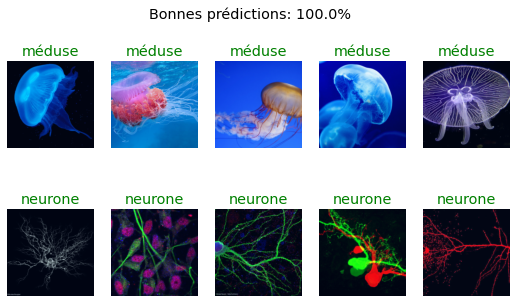

In [28]:
# Puis vérifier si il a bien appris.
fig, axs = plt.subplots(2,5,figsize=[9,5])
for batch_idx, (data, target) in enumerate(load_dataset('test_meduses_neurones',shuffle=False,batch_size=10)):
    pred = net2(data)
    good_preds = 0
    for i in range(10):
        im = data[i].permute(1,2,0)
        im = im-im.min()
        im = im/im.max()
        axs.ravel()[i].imshow(im)
        if pred[i].argmax() == target[i]:
            color = 'g'
            good_preds += 1
        else:
            color = 'r'
        axs.ravel()[i].set_title(target_index[pred[i].argmax()],color=color)
        axs.ravel()[i].axis('off')
    break
plt.suptitle('Bonnes prédictions: {:.1f}%'.format(good_preds/10*100))



La classification d'images est un problème qui est maintenant considéré résolu.


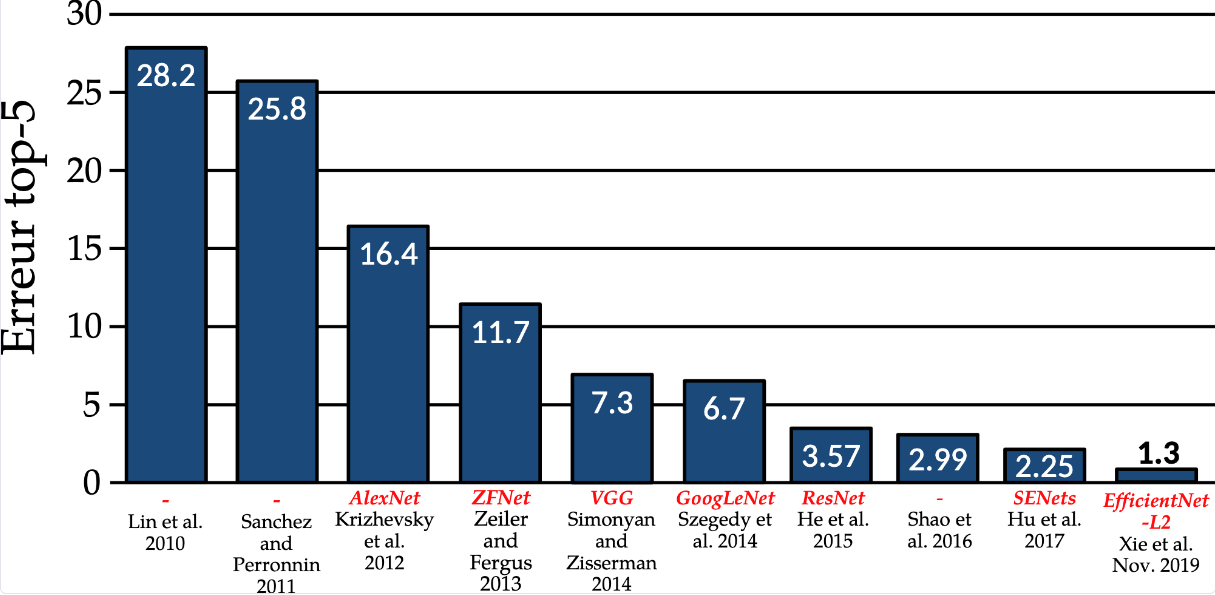


## Suivi de déplacements

<img src="https://mms.businesswire.com/media/20130724005135/en/376885/4/Copy_PerkinElmer_Single_Cell_Tracking_in_Harmony_Operetta.jpg?download=1" >

## Génération d'images et traduction de domaine


La traduction d'images d'un domaine vers un autre a son lot d'applications, pour la plupart ludiques:
- Colorisation d'images (pour l'essayer: [Image Colorization API](https://deepai.org/machine-learning-model/colorizer)<br><img src="https://www.imaging-resource.com/?ACT=44&fid=17&d=6083&f=colorize-cow-comparison.jpg" width="300">

- Transfomer des zèbres en chevaux: [Cycle-GAN](https://junyanz.github.io/CycleGAN/) <br> <img src="https://i1.wp.com/theailearner.com/wp-content/uploads/2019/10/cycle-gan-zebra-horse-images.jpg?resize=431%2C402&ssl=1" width="300">

- Générer des cartes à partir d'images satellites: [Pix2Pix](https://phillipi.github.io/pix2pix/) <br> <img src="https://miro.medium.com/max/1016/1*rdUUbngKoOzutZIeVwWbPQ.png" width="300">

- Super-résolution: [TA-GAN](https://s3.valeria.science/flclab-tagan/index.html) (shameless plug) <br> <img src="https://lh3.googleusercontent.com/fife/AAWUweXcgk-00jzfiLIjioeRv4eKMHn52V0aHE9NPM-lOHeMAjSsRunDVmhObl3Zuhq9Ap83jaeZbGZaoiiNhOm3AeNQGxxoDkp-er_fCGJf-GPn9MzxL0id_nMubiZ0ERWjGhZKlyWcIePcm9krhWiH0l-Ea1g92CvoSxGaG6taaBDfIBVyAKOyaExygpdZE9eH82toQP3FGVcajUZk-CyCT-Twsbc_Fqgv9ie_rGgrNwztUp17YLJBhWEUMSUNd5IhB7ILIag0ZC8N57V1QLieVNke7OrwAyOZZxI23ZdWEXIaiqZkBkoUWd4iQgbs9PvxF5EQslpxFE2i2hsZr7Ir7vDZHFVHhTCL7_AYsp8qDM14OQSbI2an65GI9HvJmyhgKYi6F1eQQzlsYY3LNfxA2l49akIb93ighpWY42lRqsMNj55AujcaQWEBRYA7D5F7ZxVYAr6zCyjn7ONJbhUupodFqxYexei2ukFOLZ1ZXv1nF4o_imHI6K1VMczRJ0UB0qLdEbNoSVEot_K6UNbekBp1_-rQJdEyPXXbkzlnVH2mJR0LTyYQ_UU9imMUczrORSpN-PLgfXJiR7jy1pQ-k8eK6YR2kGXtBhJvByLrgjFGGJWhgaUEhcMmnctlAWPgGjV_knhBqv3fi39FYH_8XwCTZTbAfhShyIq8MiewGPaA4WPJhiYai4EllbpaHbntdgSF8aoBExPbauev6Hn7UBDwqbw=w1853-h949" width="400">

La génération d'images a des applications similaires, mais les images sont créées au hasard, à partir d'un vecteur de bruit, plutôt que traduites à partir d'une image réelle:

- Generation of human faces ([ThisPersonDoesNotExist)](https://thispersondoesnotexist.com/)): <br> <img src="https://cdn.vox-cdn.com/thumbor/1ck1fQL62j2GaDvOlnJu4fyuIIc=/0x0:3049x2048/1200x800/filters:focal(1333x1562:1819x2048)/cdn.vox-cdn.com/uploads/chorus_image/image/63058104/fake_ai_faces.0.png" width="300">

- Generation of cat faces [(ThisCatDoesNotExist)](https://thiscatdoesnotexist.com/): <br> <img src="https://thiscatdoesnotexist.com/" width="300">

- ... and so much more: [(ThisXDoesNotExist)](https://thisxdoesnotexist.com/)


Toutes les images présentées dans cette cellule sont prpduites à partir de *Generative Adversarial Networks* ([GAN](https://arxiv.org/abs/1406.2661)). Ce modèle comprend deux réseaux à convolution entraînés simultanément, un générateur et un discriminateur:

- Générateur : réseau entièrement convolutif qui construit une image à partir d'une valeur aléatoire (GAN) ou d'une image (GAN conditionnel). 

- Discriminateur : réseau convolutif de classification, dont la tâche est de différencier les images réelles des images générées.

<br><img src="https://miro.medium.com/max/3840/1*UMg_hfitiq_XlMJUn_fzFw.jpeg">
[source](https://towardsdatascience.com/a-new-way-to-look-at-gans-7c6b6e6e9737)

# Points de repère pratiques pour démarrer un projet d'apprentissage profond

---



### Vérifier si l'apprentissage profond se porte bien à la tâche
- Commencez par tester des méthodes d'apprentissage machine plus simples: 
  - [Support Vector Machines (SVM)](https://scikit-learn.org/stable/modules/svm.html) <br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png" width="200" align="center"/><br>
  - [Random forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) <br><img src="https://i.stack.imgur.com/IvGZa.png" width="300" align="center"><br><br>
  - [Principal Component Analysis (PCA)](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) <br> <br><img src="https://miro.medium.com/max/700/1*XFSxzNm2LWbVxKsHxkFwiQ.png" width="500" align="center"/><br>
  2D Scatter plot of MNIST data after applying PCA (n_components = 50) and then t-SNE (source: https://towardsdatascience.com/dimensionality-reduction-using-t-distributed-stochastic-neighbor-embedding-t-sne-on-the-mnist-9d36a3dd4521)<br><br>
  - [Threshold based segmentation](https://en.wikipedia.org/wiki/Thresholding_(image_processing))<br><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/cancer-cell-segmentation.png" width="300" align="center"/><br><br>
  - [Clustering](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)<br><img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/02/k-means-sagemaker-1.gif" width="300" align="center">
  - [Other classical methods](https://arxiv.org/ftp/arxiv/papers/1707/1707.02051.pdf). 

### Définir la tâche
- Segmentation? Classification? Détection? Génération?
- Combien de classes? Quel type de segmentation? Sémantique, d'instance, binaire?
- Comment la performance sera évalulée? Est-ce que les faux positifs ont le même impact que les faux négatifs?

### Préparer les données
- Combien d'images sont disponibles? Quelles annotations sont disponibles?
- Est-ce que les classes sont bien balancées? Est-ce qu'elles devraient l'être?
- Quelles méthodes d'augementation de données sont applicables? Par exemples, les nombres ne sont pas invariants en rotation (un **6** à l'envers devrait être classé comme un **9**, mais son étiquette est **6**!)
<br>
<img src="https://i.stack.imgur.com/Momu1.jpg" width="300" align="left"/>
<br><br><br><br>

### Choisir l'architecture du réseau
- Est-ce qu'un réseau pré-entraîné pour la tâche est disponible? (e.g [torchvision] library (https://pytorch.org/vision/stable/models.html))
- Consultez la littérature pour identifier quel modèle est le plus performant pour votre tâche:
  - Classification, beaucoup d'images: [ResNeXt-101-32x8d](https://arxiv.org/abs/1611.05431v2)
  - Classification, peu d'images: [VGG-11](https://arxiv.org/abs/1409.1556), [AlexNet](https://arxiv.org/abs/1404.5997)
  - Segmentation: [U-Net](https://arxiv.org/abs/1505.04597)
  - Détection d'instance: [Mask-RCNN](https://arxiv.org/abs/1703.06870)

- Attention : les réseaux plus profonds sont généralement plus efficaces, mais leur formation nécessite beaucoup plus de données et de ressources informatiques.

### Sélection des hyper-paramètres
- Consultez les articles publiés qui utilisent une méthode similaire pour une tâche similaire et examinez les hyperparamètres utilisés. 
- Si l'entraînement est efficace en termes de ressources et de temps, reproduisez plusieurs entraînements avec des hyperparamètres variables (recherche par grille).
- Examinez l'évolution des pertes de validation et d'apprentissage ; si les pertes oscillent beaucoup entre les époques, vous pouvez envisager de réduire le taux d'apprentissage ou d'augmenter la taille de batch. Si les pertes convergent mais pas les performances réelles, envisagez d'utiliser une fonction objectif différente, mieux adaptée à votre tâche spécifique.

<img src="https://forums.fast.ai/uploads/default/optimized/2X/5/5040a66e70fdc509e6b13a50ba78533009079c5a_2_690x426.png">
Source: https://forums.fast.ai/t/determining-when-you-are-overfitting-underfitting-or-just-right/7732/9

# Ressources

### Analyse d'images

- Python libraries: [10 Python image manipulation tools](https://towardsdatascience.com/image-manipulation-tools-for-python-6eb0908ed61f)
  - [scikit-image](https://scikit-image.org/) (Free collection of algorithms for image processing)
  - [PIL](https://pillow.readthedocs.io/en/stable/) (Python Imaging Library)
  - [numpy](https://numpy.org/) (Remember: images are matrices!)
- [Pytorch tutorials](https://pytorch.org/tutorials/)
- Plugins for ImageJ : https://imagej.net/Category:Plugins

### Apprentissage Profond

- [Pytorch](https://pytorch.org/)
- For a theoretical understanding : [Deep Learning Book](https://www.deeplearningbook.org/)
- In-depth publications about data science, often with code snippets to help understand the concepts explained : [Towards Data Science](https://towardsdatascience.com/machine-learning/home)
- Youtube channel [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw)

### Ressources de calcul

- [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index) (Zero configuration required, Free access to GPUs, Easy sharing)